# Geotiff Interpolation Tutorial

The purpose of this notebook is to demonstrate interpolation from geotiff files to lon/lat pairs. In this case, the geotiff files are bands from HRRR grib2 files collected using `wrfxpy` methods on Alderaan. The lon/lat pairs are collected from RAWS stations with `Mesopy`.

The tiff files are saved with naming a convention that stores the UTC time info as well as the associated band. See:

https://www.nco.ncep.noaa.gov/pmb/products/hrrr/hrrr.t00z.wrfprsf00.grib2.shtml

# Setup 

In [1]:
import os
import os.path as osp
import numpy as np
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
path = os.getcwd()
tpath = osp.join(path,"hrrr.t00z.wrfprsf00.616.tif")

In [3]:
# Get RAWS Station lat/lon
sts = pd.read_csv("C:/Users/jhirs/Documents/Projects/openwfm/notebooks/fmda/data/raws_stations_CO.csv")
sts

,STID,air_temp,relative_humidity,precip_accum,fuel_moisture,wind_speed,solar_radiation,lon,lat
0,KAFF,1,1,0,0,1,0,-104.81667,38.96667
1,KAKO,1,1,0,0,1,0,-103.21459,40.17428
2,KALS,1,1,0,0,1,0,-105.86180,37.43933
3,KAPA,1,1,0,0,1,0,-104.84841,39.55991
4,KASE,1,1,0,0,1,0,-106.87051,39.22992
...,...,...,...,...,...,...,...,...,...
1212,G1361,1,1,0,0,1,1,-105.10750,39.69883
1213,G1378,1,1,0,0,1,0,-105.42250,39.48917
1214,G1550,1,1,0,0,1,1,-105.01517,38.45217
1215,G1725,1,1,0,0,1,1,-105.05217,40.56150


In [4]:
# Extract data from tif file
ds = gdal.Open(tpath)
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
gp = ds.GetProjection()
# data = np.array(ds.ReadAsArray())

In [5]:
print(width)
print(height)
print(gt)
print(gp)

1799
1059
(-2699020.142521929, 3000.0, 0.0, 1588193.847443335, 0.0, -3000.0)
PROJCS["unnamed",GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6371229,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",38.5],PARAMETER["central_meridian",-97.5],PARAMETER["standard_parallel_1",38.5],PARAMETER["standard_parallel_2",38.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [6]:
print('Raster count: ' + str(ds.RasterCount))

Raster count: 1


In [7]:
band = ds.GetRasterBand(1)
data = band.ReadAsArray()

# Plot Raster File

Using `imshow`, add a point at 100,100 just to demonstrate image indexing.

source: https://www.geeksforgeeks.org/visualizing-tiff-file-using-matplotlib-and-gdal-using-python/

Text(100, 100, '(100,100)')

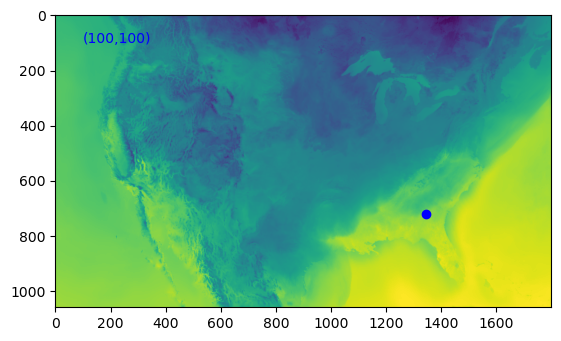

In [8]:
# Plot
plt.imshow(data)
plt.plot(1345, 721, marker='o', color='blue', markersize=6)
plt.annotate("(100,100)", (100,100), color='blue')

# Interp Lat/Lon

Source (nearest neighbor method): https://stackoverflow.com/questions/69034965/given-a-geotiff-file-how-does-one-find-the-single-pixel-closest-to-a-given-lati

In [9]:
point_srs = osr.SpatialReference()
point_srs.ImportFromEPSG(4326) # hardcode for lon/lat

# GDAL>=3: make sure it's x/y
# see https://trac.osgeo.org/gdal/wiki/rfc73_proj6_wkt2_srsbarn
point_srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)     

file_srs = osr.SpatialReference()
file_srs.ImportFromWkt(gp)

0

In [10]:
ct = osr.CoordinateTransformation(point_srs, file_srs)

point_x = sts['lon'][0] # lon
point_y = sts['lat'][0]  # lat
mapx, mapy, z = ct.TransformPoint(point_x, point_y)

In [11]:
gt_inv = gdal.InvGeoTransform(gt)
pixel_x, pixel_y = gdal.ApplyGeoTransform(gt_inv, mapx, mapy)

We plot the image with the pixel annotated. The lon/lat pair is from a RAWS station near Colorado Springs, which matches the image below.

Text(589.025656424631, 453.722879875854, 'Lon/Lat: (-104.82, 38.97)')

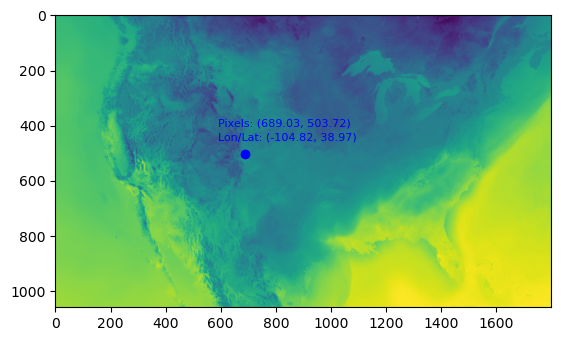

In [12]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6)
plt.annotate(f"Pixels: ({round(pixel_x, 2)}, {round(pixel_y, 2)})", xy=(pixel_x, pixel_y),
            xytext=(pixel_x-100, pixel_y-100), fontsize=8, color='blue')
plt.annotate(f"Lon/Lat: ({round(point_x, 2)}, {round(point_y, 2)})", xy=(pixel_x, pixel_y),
           xytext=(pixel_x-100, pixel_y-50), fontsize=8, color='blue')

After this point, the tutorial goes on to describe a method for nearest neighbor. This is just one form of interpolation, so various methods will be explored below.

We will plot a zoomed in version of the pixels to demonstrate this.

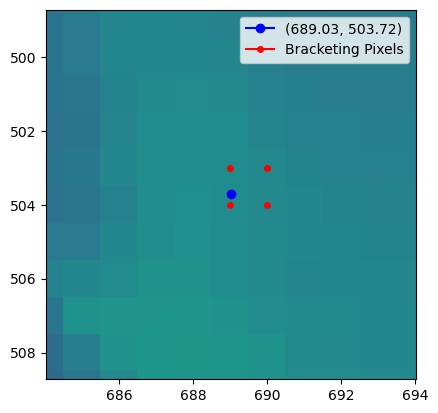

In [13]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6,
        label=f"({round(pixel_x, 2)}, {round(pixel_y, 2)})")

# Zoom in, set limits from plotted pixel
offset = 5
plt.xlim(pixel_x-offset, pixel_x+offset) # Note different +/- bc origin is topright
plt.ylim(pixel_y+offset,pixel_y-offset)

# Plot 4 points bracketing target pixel
x1, y1=np.floor(pixel_x), np.floor(pixel_y)
x2, y2=np.floor(pixel_x), np.ceil(pixel_y)
x3, y3=np.ceil(pixel_x), np.floor(pixel_y)
x4, y4=np.ceil(pixel_x), np.ceil(pixel_y)

plt.plot(x1,y1, marker='o', color='red', markersize=4, label='Bracketing Pixels')
plt.plot(x2,y2, marker='o', color='red', markersize=4)
plt.plot(x3,y3, marker='o', color='red', markersize=4)
plt.plot(x4,y4, marker='o', color='red', markersize=4)

plt.legend()

# Interpolation Methods

## Nearest Neighbor (L1)

The tutorial linked above simply rounds the pixel x and y coordinates to the nearest pixels and takes the value from that grid location. This is mathematically equivalent to an L1 nearest neighbor, or manhattan distance minimization.

In [14]:
# round to pixel
x_l1 = round(pixel_x)
y_l1 = round(pixel_y)

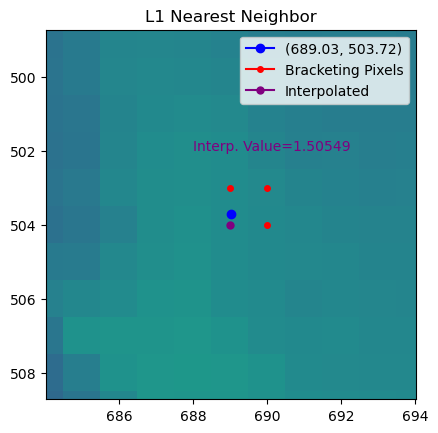

In [15]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6,
        label=f"({round(pixel_x, 2)}, {round(pixel_y, 2)})")

# Zoom in, set limits from plotted pixel
offset = 5
plt.xlim(pixel_x-offset, pixel_x+offset) # Note different +/- bc origin is topright
plt.ylim(pixel_y+offset,pixel_y-offset)

# Plot 4 points bracketing target pixel
x1, y1=np.floor(pixel_x), np.floor(pixel_y)
x2, y2=np.floor(pixel_x), np.ceil(pixel_y)
x3, y3=np.ceil(pixel_x), np.floor(pixel_y)
x4, y4=np.ceil(pixel_x), np.ceil(pixel_y)

plt.plot(x1,y1, marker='o', color='red', markersize=4, label='Bracketing Pixels')
plt.plot(x2,y2, marker='o', color='red', markersize=4)
plt.plot(x3,y3, marker='o', color='red', markersize=4)
plt.plot(x4,y4, marker='o', color='red', markersize=4)

# Plot interpolated pixel
plt.plot(x_l1,y_l1, marker='o', color='purple', markersize=5,
        label='Interpolated')
interp_val = data[y_l1, x_l1]
plt.annotate("Interp. Value="+str(round(interp_val, 5)), xy=(x_l1, y_l1), xytext=(x_l1-1, y_l1-2), color='purple')

plt.title("L1 Nearest Neighbor")
plt.legend()

NOTE: The HRRR documentation says that 2m Temperature, band 616, should be in degrees K. But obviously this data is in degrees C. We will have to check this in the future.

## Nearest Neighbor (L2)

In `wrfxpy`, the function `find_closest_grid_point` is defined to find the L2 nearest neighbor, which finds the minimum sum of squared distance (Euclidean norm).

https://github.com/openwfm/wrfxpy/blob/master/src/utils.py#L529

NOTE: very slow implementation, but I wanted to reproduce the method clearly. In this case, the interpolated value is the same as L1.

In [16]:
x = np.arange(0, band.XSize)
y = np.arange(0, band.YSize)
pixels = [(xx, yy) for xx in x for yy in y]
d = np.zeros(len(pixels))
for i in range(0, len(pixels)):
    p = pixels[i]
    d[i] = (pixel_x - p[0])**2 + (pixel_y - p[1])**2

nearest = pixels[np.argmin(d)]

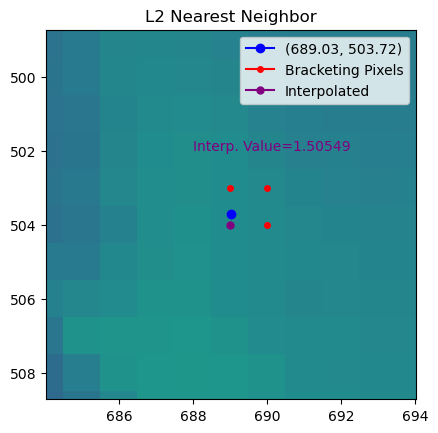

In [17]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6,
        label=f"({round(pixel_x, 2)}, {round(pixel_y, 2)})")

# Zoom in, set limits from plotted pixel
offset = 5
plt.xlim(pixel_x-offset, pixel_x+offset) # Note different +/- bc origin is topright
plt.ylim(pixel_y+offset,pixel_y-offset)

# Plot 4 points bracketing target pixel
x1, y1=np.floor(pixel_x), np.floor(pixel_y)
x2, y2=np.floor(pixel_x), np.ceil(pixel_y)
x3, y3=np.ceil(pixel_x), np.floor(pixel_y)
x4, y4=np.ceil(pixel_x), np.ceil(pixel_y)

plt.plot(x1,y1, marker='o', color='red', markersize=4, label='Bracketing Pixels')
plt.plot(x2,y2, marker='o', color='red', markersize=4)
plt.plot(x3,y3, marker='o', color='red', markersize=4)
plt.plot(x4,y4, marker='o', color='red', markersize=4)

# find nearest L2 pixel
plt.plot(nearest[0],nearest[1], marker='o', color='purple', markersize=5,
        label='Interpolated')
interp_val = data[nearest[1], nearest[0]]
plt.annotate("Interp. Value="+str(round(interp_val, 5)), xy=(x_l1, y_l1), xytext=(x_l1-1, y_l1-2), color='purple')


plt.title("L2 Nearest Neighbor")
plt.legend()

## Average Bracketing Points

Given the 4 bracketing points, interpolate the mean value.

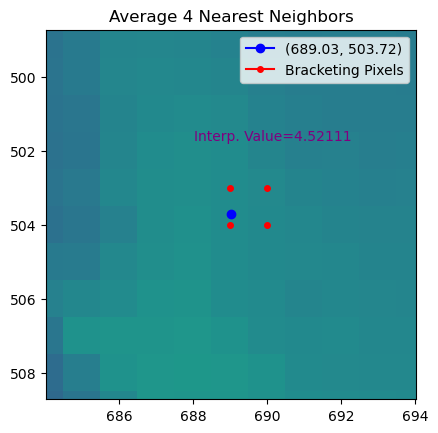

In [18]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6,
        label=f"({round(pixel_x, 2)}, {round(pixel_y, 2)})")

# Zoom in, set limits from plotted pixel
offset = 5
plt.xlim(pixel_x-offset, pixel_x+offset) # Note different +/- bc origin is topright
plt.ylim(pixel_y+offset,pixel_y-offset)

# Plot 4 points bracketing target pixel
x1, y1=int(np.floor(pixel_x)), int(np.floor(pixel_y))
x2, y2=int(np.floor(pixel_x)), int(np.ceil(pixel_y))
x3, y3=int(np.ceil(pixel_x)), int(np.floor(pixel_y))
x4, y4=int(np.ceil(pixel_x)), int(np.ceil(pixel_y))

plt.plot(x1,y1, marker='o', color='red', markersize=4, label='Bracketing Pixels')
plt.plot(x2,y2, marker='o', color='red', markersize=4)
plt.plot(x3,y3, marker='o', color='red', markersize=4)
plt.plot(x4,y4, marker='o', color='red', markersize=4)

interp_val = np.mean([data[y1, x1], data[y2, x2], data[y3, x3], data[y4, 4]])
plt.annotate("Interp. Value="+str(round(interp_val, 5)), xy=(pixel_x, pixel_y), xytext=(pixel_x-1, pixel_y-2), color='purple')


plt.title("Average 4 Nearest Neighbors")
plt.legend()

## Scipy griddata interpolation package

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

In [19]:
from scipy.interpolate import griddata

## Validate Geolocation

Steps:

* create two fake geotiff
* create data array with known lon/lat values
* give same values as longitude
* when you evaluate you should get coord back exactlystly